# Notebook 2 - Inference

In this notebook we use `harissa` to perform network inference from a small dataset with 4 genes.

In [1]:
import numpy as np
from pathlib import Path
from harissa import NetworkModel, NetworkParameter
fname = 'data.txt'
data_path = Path(fname)

## Network

Let us start by defining a test network which will represent the ground truth. Note that the underlying dynamical model has quantitative parameters.

In [2]:
# Initialize model parameters with 4 genes
param = NetworkParameter(4)

# Set degradation rates
param.degradation_rna[:] = 1.0
param.degradation_protein[:] = 0.2

# Set creation rates
param.creation_rna = param.degradation_rna * param.scale() 
param.creation_protein = param.degradation_protein * param.scale()

# Set basal activities
param.basal[1:] = -5.0

# Set interactions
param.interaction[0,1] = 10.0
param.interaction[1,2] = 10.0
param.interaction[1,3] = 10.0
param.interaction[3,4] = 10.0
param.interaction[4,1] = -10.0
param.interaction[2,2] = 10.0
param.interaction[3,3] = 10.0

# Initialize model
model = NetworkModel(param)

The `harissa.utils` module provides `build_pos` and `plot_network` to visualize networks.

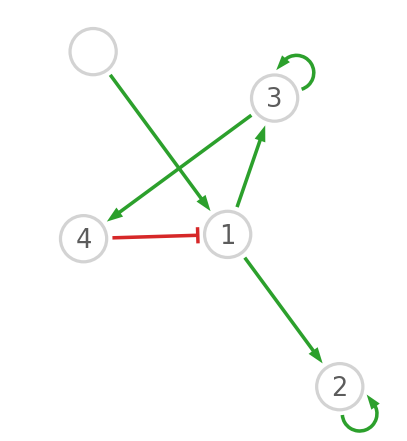

In [3]:
import matplotlib.pyplot as plt
from harissa.graphics import build_pos, plot_network

# Number of genes including stimulus
G = param.basal.size

# Node labels and positions
names = [''] + [f'{i+1}' for i in range(G)]
pos = build_pos(param.interaction) * 0.8

# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(param.interaction, pos, axes=fig.gca(), names=names, scale=3)

## Dataset

We start by generating a sample time-course scRNA-seq dataset: here the main function is `model.simulate()`. The dynamical model is first run during a certain time without stimulus (`burnin` parameter) before activating it at $t=0$. Each single cell is then collected at a particular time point $t > 0$ during the simulated experiment: in this example there are 10 experimental time points and `C`/10 cells per time point.

In [10]:
# Simulate a time-course scRNA-seq dataset
if not data_path.is_file():
    # Number of cells
    C = 1000
    # Set the time points
    k = np.linspace(0, C, 11, dtype='int')
    t = np.linspace(0, 20, 10, dtype='int')
    print('Time points: ' + ', '.join([f'{ti}' for ti in t]))
    print(f'{int(C/t.size)} cells per time point (total {C} cells)')
    # Time point of each cell
    time = np.zeros(C, dtype='int')
    for i in range(10):
        time[k[i]:k[i+1]] = t[i]
    # Prepare data
    data = np.zeros((C,G), dtype='int')
    data[:,0] = time # Time points
    # Generate data
    for k in range(C):
        sim = model.simulate(time[k], burn_in=5.0)
        data[k,1:] = np.random.poisson(sim.rna_levels[0])
    # Save data in basic format
    np.savetxt(fname, data, fmt='%d', delimiter='\t')
    print(f'Dataset file {fname} has been generated.')
else:
    data = np.loadtxt(fname, dtype=int, delimiter='\t')
    print(f'Dataset file {fname} loaded.')

Dataset file data.txt loaded.


Note that each scRNA-seq count is obtained by sampling from a Poisson distribution whose rate (mean) parameter is given by the corresponding continuous-valued mRNA level from the stochastic dynamical model. A typical way to implement technical factors (efficiency of reverse transcription, sequencing depth, etc.) would be to first multiply, before applying the Poisson distribution, the continuous values by scaling factors.

In [5]:
print(data)

[[  0   0   0   0  73]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 ...
 [ 20   3  16 312 121]
 [ 20   0  96   9  59]
 [ 20  47  34 235  42]]


Each row corresponds to a single cell; the first column contains time points, while other columns contain gene expression counts.

## Network Inference

Here the main function is `model.fit()`. The first call may take a while due to the Numba compilation (activated by default).

In [11]:
model1 = NetworkModel()
# Calibrate the model
res = model1.fit(data).parameter
# Show inferred links
print(res.interaction)

[[-- 3.9754796883104984 0.21190357986569638 0.15843723866342338
  0.09166389283722816]
 [-- 4.90789049417983 2.2320194191582585 2.2022738156652397
  0.07639515011378312]
 [-- -0.050326897643683026 5.392088523777237 0.7296655603314094
  0.84324086644988]
 [-- -0.06435599308513723 0.9476408977624573 5.37514211434903
  0.7725560419540258]
 [-- -2.104581618556363 0.3264383292257651 0.37228455521208803
  5.252058016641176]]



Note that the first column of `model.inter` will always be 0 since the stimulus (gene 0) has no feedback by hypothesis. In order to better visualize the results, we can apply a cutoff to edge weights:

In [7]:
cutoff = 1
inter_c = (np.abs(res.interaction) > cutoff) * res.interaction
print(inter_c) 

[[-- 3.9754796883104984 0.0 0.0 0.0]
 [-- 4.90789049417983 2.2320194191582585 2.2022738156652397 0.0]
 [-- -0.0 5.392088523777237 0.0 0.0]
 [-- -0.0 0.0 5.37514211434903 0.0]
 [-- -2.104581618556363 0.0 0.0 5.252058016641176]]


Hopefully this looks nice!

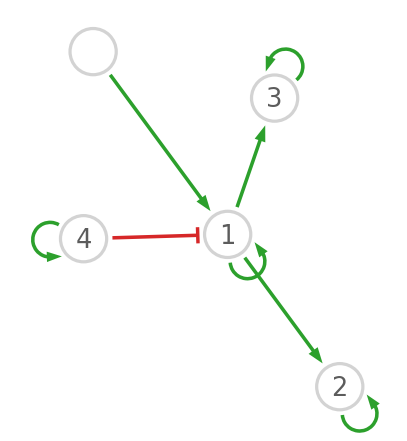

In [8]:
# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(inter_c, pos, axes=fig.gca(), names=names, scale=3)

Note that self-interactions are notoriously difficult to infer; they are usually not considered in performance evaluations.

### Option: disable Numba

To perform inference without Numba acceleration, set the `use_numba` option to `False` (useful when Numba is not available or generates errors).

In [9]:
from harissa.inference import Hartree
model2 = NetworkModel(inference=Hartree(use_numba=False))
# Calibrate the model
model2.fit(data)
# Show inferred links
print(model2.parameter.interaction)

[[-- 3.9754796883104984 0.21190357986569638 0.15843723866342338
  0.09166389283722816]
 [-- 4.90789049417983 2.2320194191582585 2.2022738156652397
  0.07639515011378312]
 [-- -0.050326897643683026 5.392088523777237 0.7296655603314094
  0.84324086644988]
 [-- -0.06435599308513723 0.9476408977624573 5.37514211434903
  0.7725560419540258]
 [-- -2.104581618556363 0.3264383292257651 0.37228455521208803
  5.252058016641176]]


You can now delete `data.txt` and try to generate new data with different values for `C` (number of cells) to see its impact on performance.